<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_79).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Motorizacion Turismos)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Index_Turisme']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2628 entries, 4380 to 7007
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   2628 non-null   int64  
 1   Trimestre             2628 non-null   int64  
 2   Mes                   2628 non-null   int64  
 3   Codi_Districte        2628 non-null   int64  
 4   Nom_Districte         2628 non-null   object 
 5   Codi_Barri            2628 non-null   int64  
 6   Nom_Barri             2628 non-null   object 
 7   Compraventa_Unitario  2628 non-null   float64
 8   Index_Turisme         2628 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 205.3+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Index_Turisme
Fecha,,,,,,,,,
2019-01-01,2019,1,1,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-02-01,2019,1,2,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-03-01,2019,1,3,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-04-01,2019,2,4,1,Ciutat Vella,1,el Raval,3838.4,122.718571
2019-05-01,2019,2,5,1,Ciutat Vella,1,el Raval,3838.4,122.718571


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-01-01,2242.453846,280.495356
2019-02-01,2242.453846,280.495356
2019-03-01,2242.453846,280.495356
2019-04-01,2145.500000,280.495356
2019-05-01,2145.500000,280.495356


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2019-01-01 to 2021-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  36 non-null     float64
 1   Index_Turisme         36 non-null     float64
dtypes: float64(2)
memory usage: 864.0 bytes


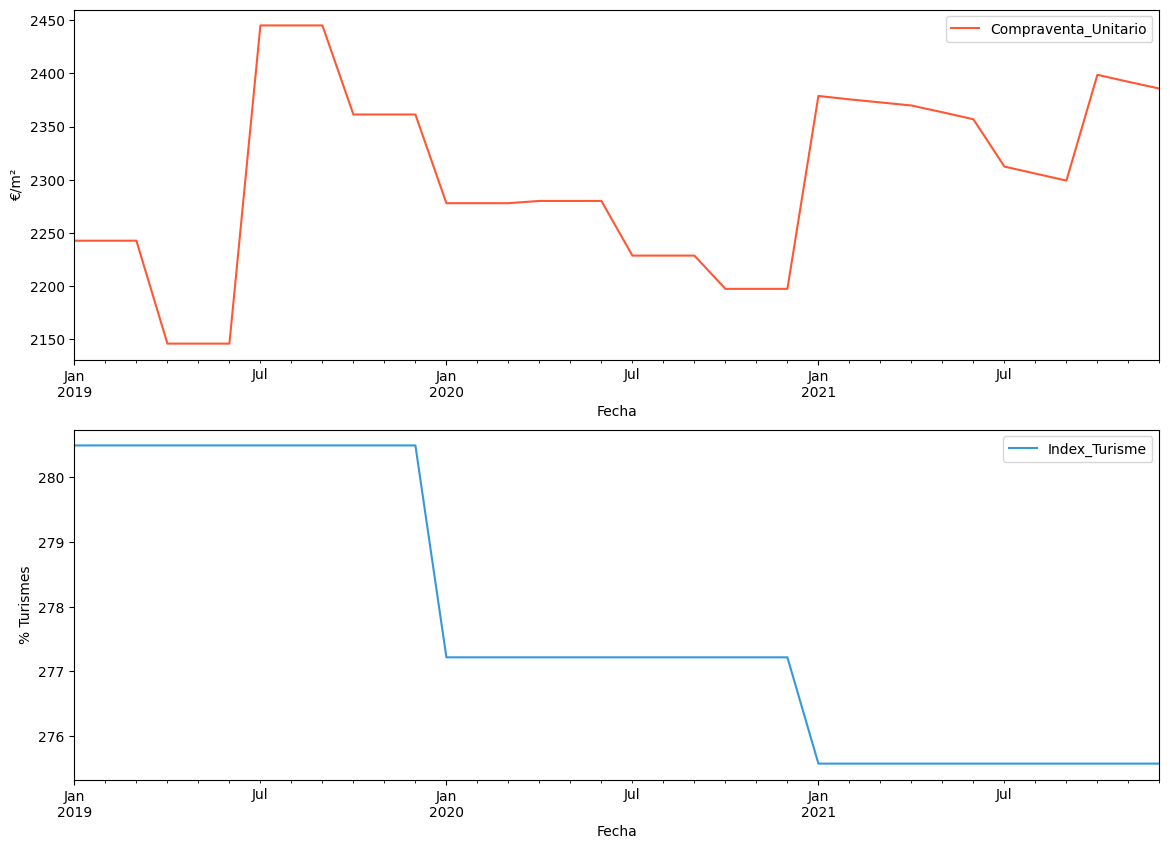

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Turismes' ]
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Index_Turisme
Compraventa_Unitario,1.00000,-0.19876
Index_Turisme,-0.19876,1.00000


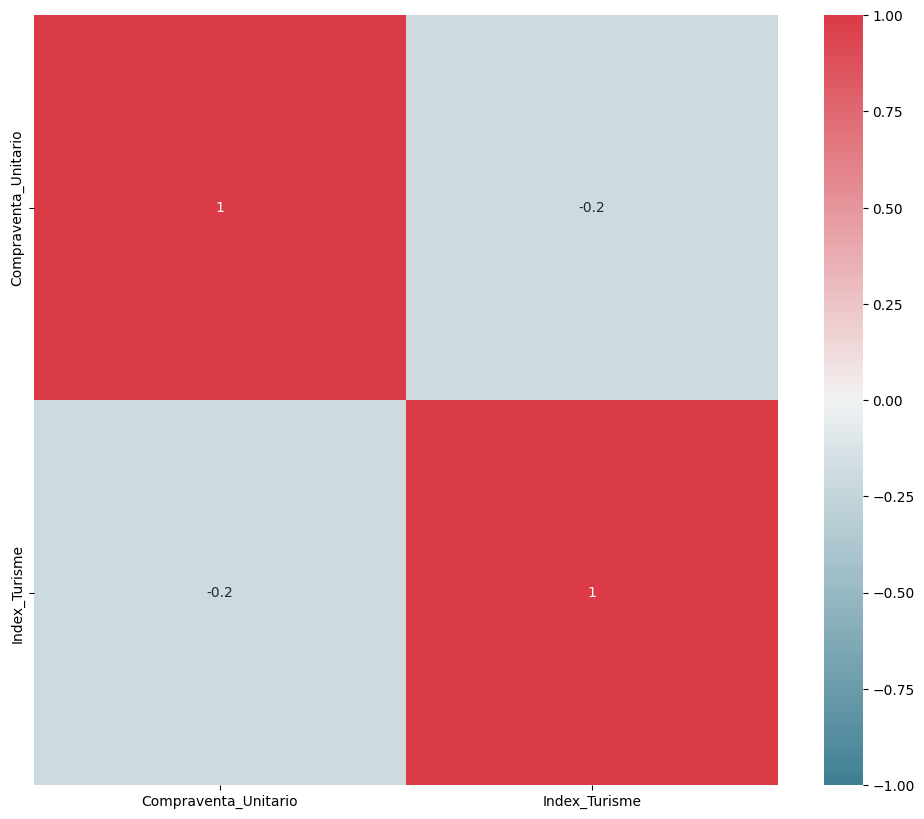

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" e "Index_Turisme" es de -0.19876, lo que sugiere una correlación negativa débil entre estas dos variables en tus datos.

##### Dividir los datos en conjunto de Entrenamiento y Prueba


In [18]:
fecha_division = '2021-07-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(30, 2) (6, 2)


Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [17]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario','Index_Turisme']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  55.98     > 12.3212   =>   True
Index_Turisme >  6.37      > 4.1296    =>   True


- Compraventa_Unitario muestra evidencia de cointegración, lo que sugiere que las variables incluidas tienen una tendencia a largo plazo a moverse juntas, manteniendo una relación de equilibrio.

- Index_Turisme muestra evidencia de cointegración, lo que sugiere que las variables incluidas tienen una tendencia a largo plazo a moverse juntas, manteniendo una relación de equilibrio.

Para un análisis conjunto, dado que una de las series esta cointegrada y la otra no, se consideran principalmente 2 modelos, VAR y VECM



##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.184481
Serie de tiempo Index_Turisme
p-value: 0.826668


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-02-01,0.000000,0.0
2019-03-01,0.000000,0.0
2019-04-01,-96.953846,0.0
2019-05-01,0.000000,0.0
2019-06-01,0.000000,0.0


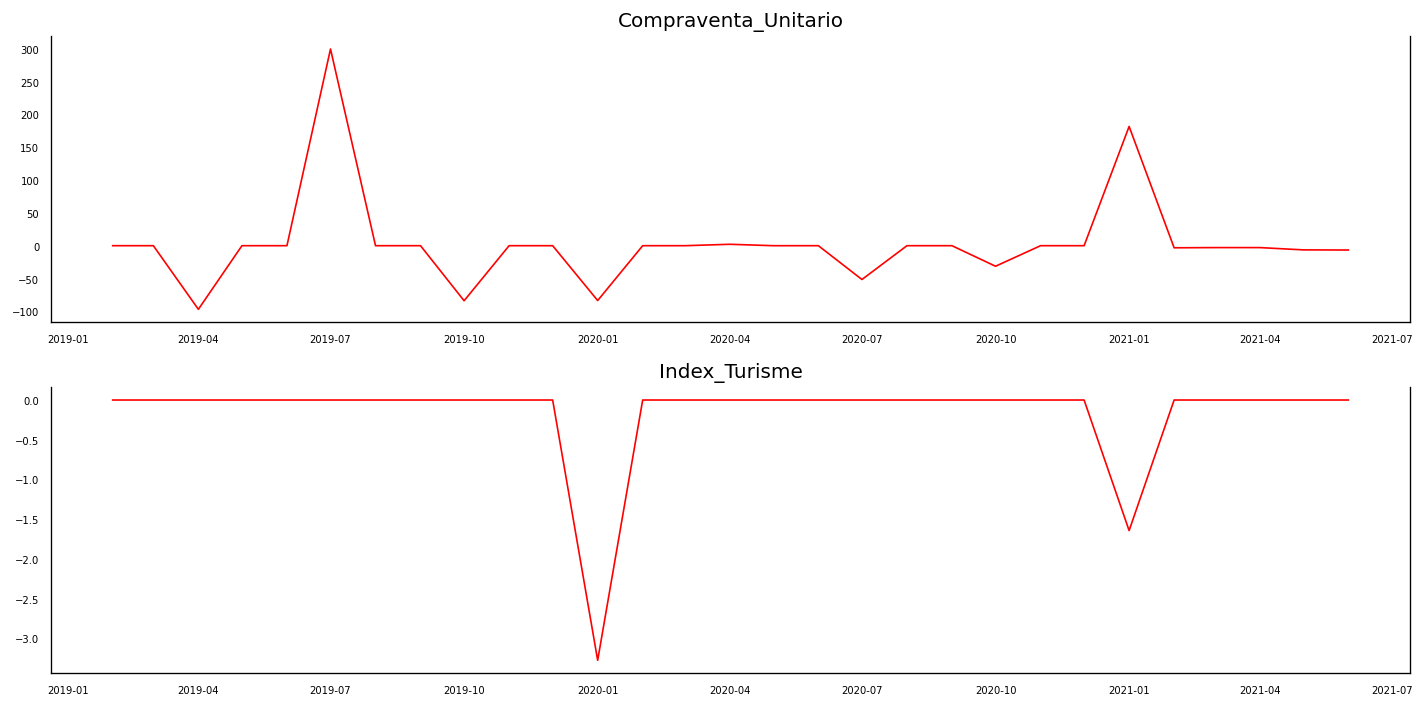

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000012
Serie de tiempo transformada Variable Index_Turisme
p-value: 0.000002


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 1 orden de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [25]:
from statsmodels.tsa.api import VAR

In [26]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [27]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,7.435,7.535*,1695.*,7.457*
1,7.805,8.104,2464.,7.870
2,8.173,8.671,3611.,8.281
3,8.371,9.067,4554.,8.522
4,8.713,9.608,6842.,8.907
5,9.030,10.12,1.052e+04,9.267
6,7.308*,8.601,2265.,7.589
7,7.595,9.087,4111.,7.919
8,7.805,9.496,8688.,8.172


Dado que el AIC alcanza sus valores mínimos en el orden 6 , y que el BIC, FPE y HQIC destacan el orden 0, generalmente se prefiere seguir la mayoría de los criterios, especialmente en presencia de una fuerte señal en AIC, FPE y HQIC. Esto sugiere que el modelo VAR de orden 6 es el más adecuado para los datos, proporcionando un buen equilibrio entre ajuste del modelo y penalización por aumentar la complejidad del modelo.

#### Ajustando el modelo

In [28]:
res = model.fit(maxlags=6)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, May, 2024
Time:                     13:39:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.25241
Nobs:                     23.0000    HQIC:                   7.29163
Log likelihood:          -119.413    FPE:                    1436.28
AIC:                      6.96881    Det(Omega_mle):         586.259
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          12.442993        17.306259            0.719           0.472
L1.Compraventa_Unitario        -0.041469         0.159261           -0.260           0.795
L1.In

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Index_Turisme" es de -0.724795, lo que sugiere una correlación negativa alta entre los residuos de estas dos variables en los datos.

In [29]:
res.is_stable()

True

In [30]:
X_train.columns

Index(['Compraventa_Unitario', 'Index_Turisme'], dtype='object')

###### Causalidad de Granger

In [31]:
grangercaus=res.test_causality(['Index_Turisme'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
2.789,2.599,0.039,"(6, 20)"


In [32]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Index_Turisme'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.5203,2.599,0.786,"(6, 20)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=3
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Index_Turisme_x
Compraventa_Unitario_y,1.0000,0.9221
Index_Turisme_y,0.5809,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

#### Diagnosis del modelo


###### Residuos

In [34]:
residuals=res.resid

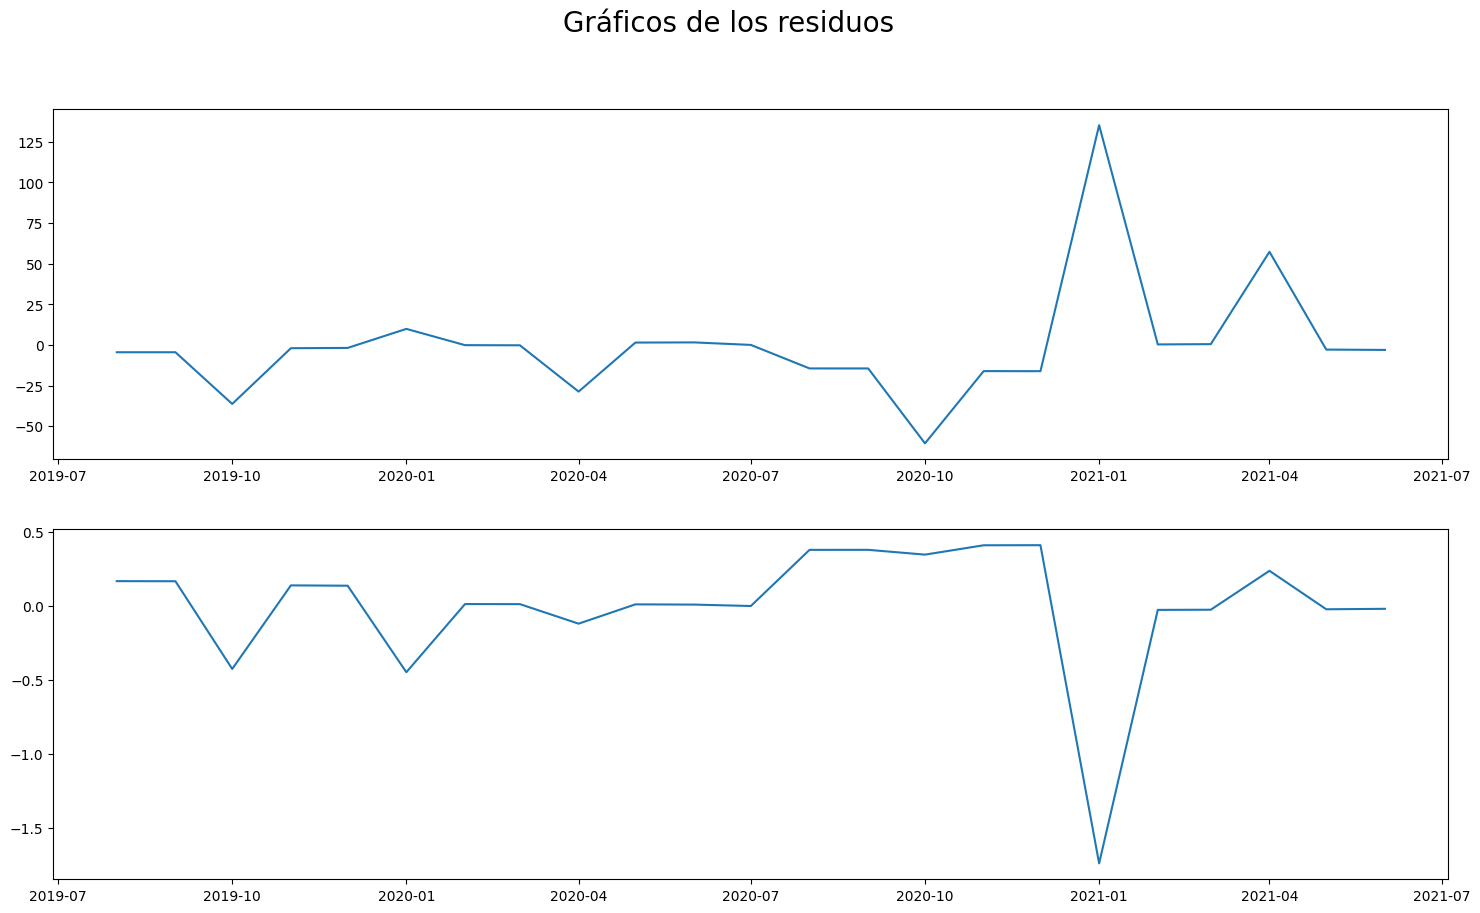

In [35]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [36]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[0.0002600280625553942, 6.780584401889078e-05]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


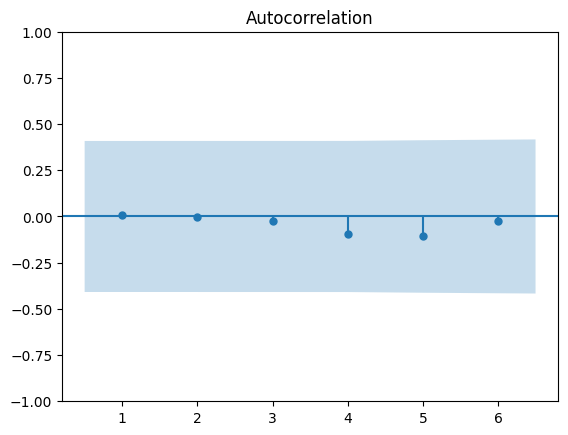

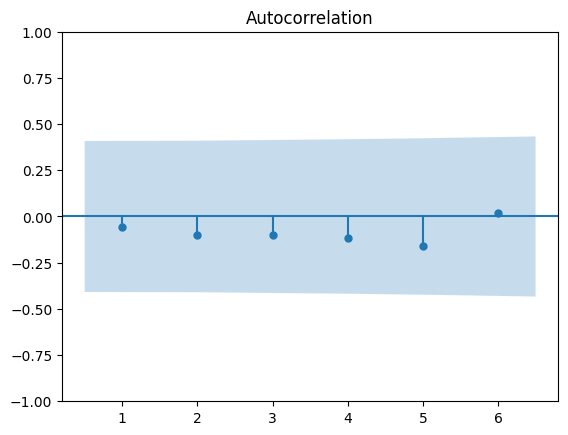

In [38]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 6) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


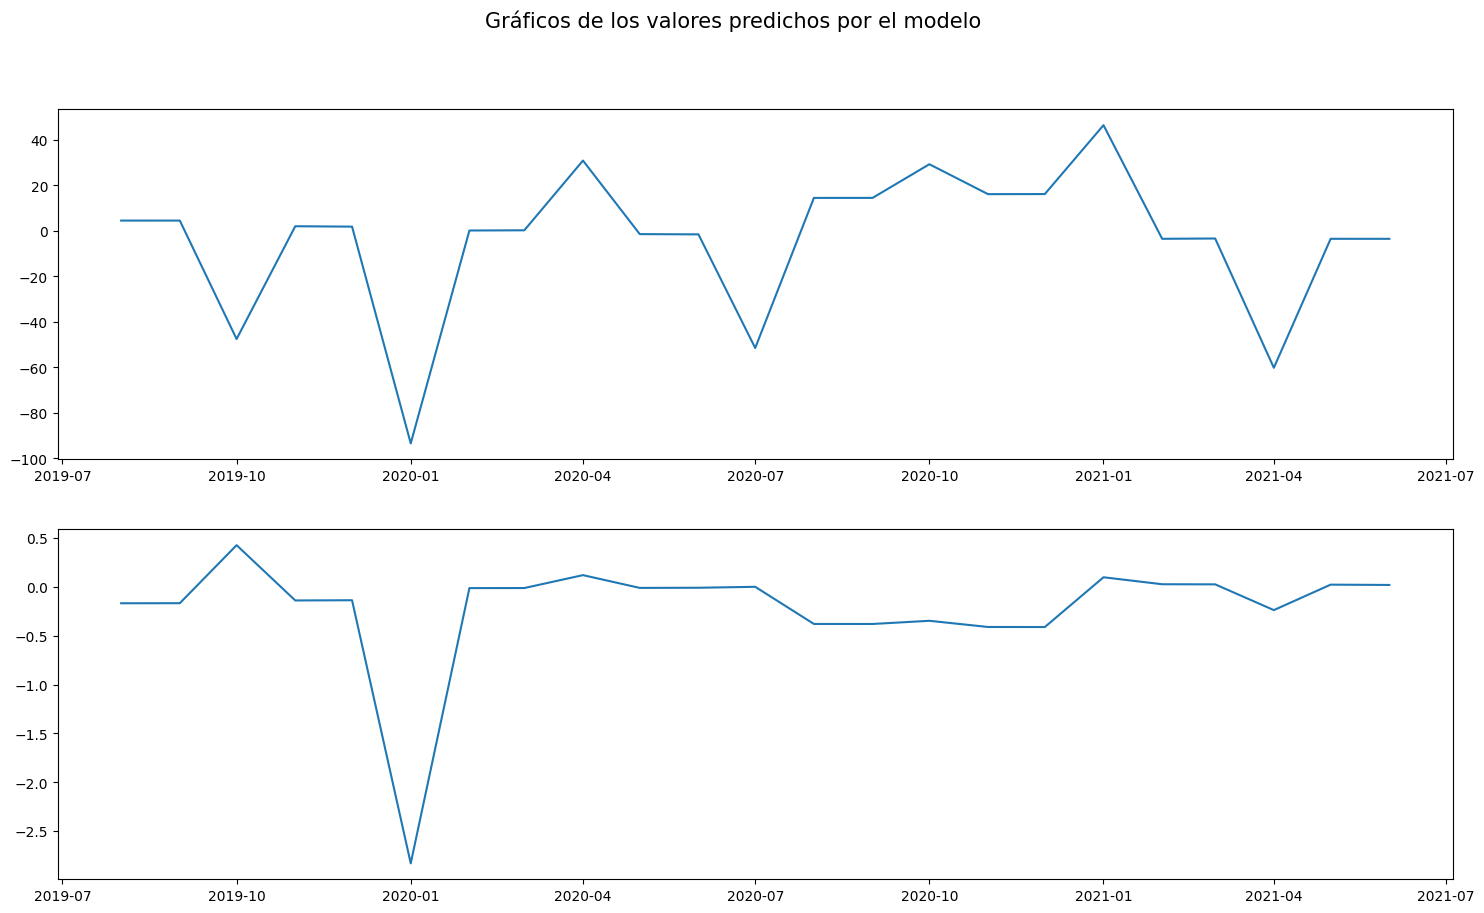

In [39]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [40]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=6)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 6
Predicciones:


,Compraventa_Unitario_pred,Index_Turisme_pred
Fecha,,
2021-07-01,-118.075985,-2.053344
2021-08-01,9.219322,-0.126604
2021-09-01,7.936118,-0.099993
2021-10-01,22.917220,-0.420369
2021-11-01,0.579095,-0.056119
2021-12-01,0.634099,-0.034289


<Figure size 1200x1000 with 0 Axes>

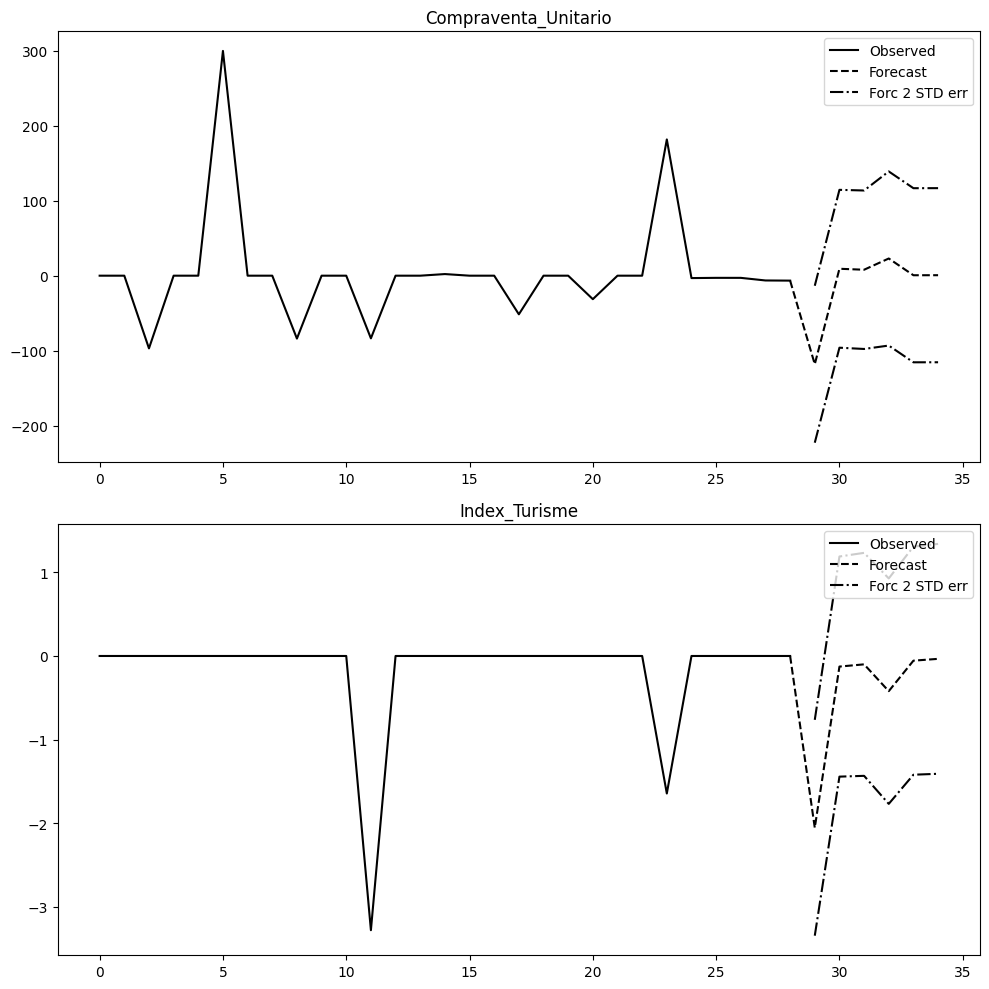

In [41]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [42]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [43]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=False)
output

,Compraventa_Unitario,Index_Turisme
Fecha,,
2021-07-01,2238.766735,273.520165
2021-08-01,2247.986056,273.393562
2021-09-01,2255.922174,273.293569
2021-10-01,2278.839394,272.873200
2021-11-01,2279.418489,272.817081
2021-12-01,2280.052588,272.782792


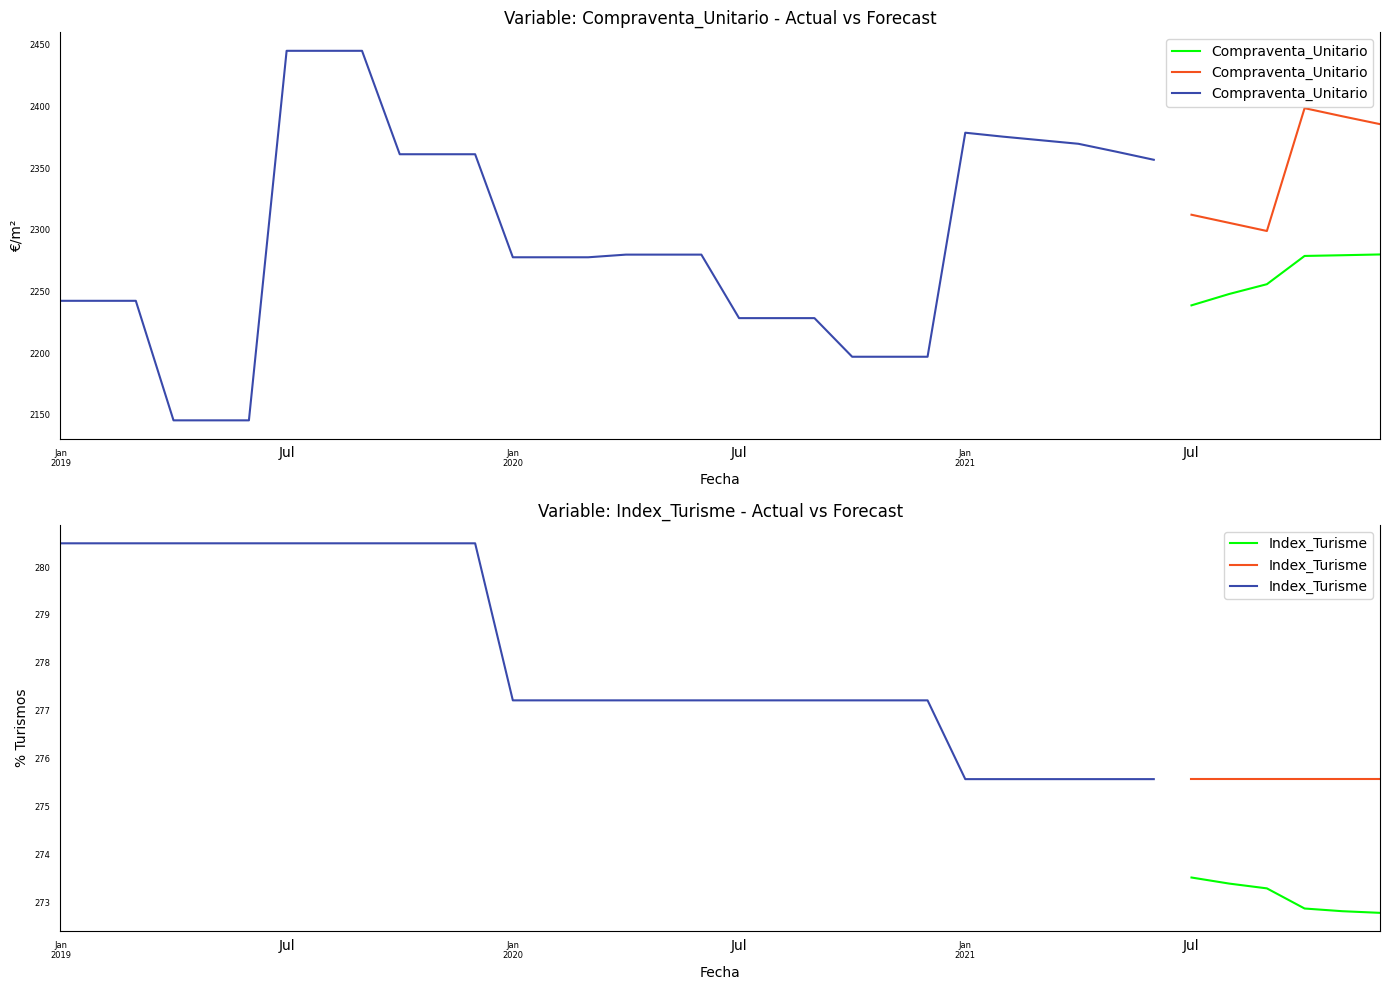

In [44]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Turismos']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [45]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [46]:
for i in ['Compraventa_Unitario','Index_Turisme']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 8139.164976101539
MAE is : 85.43575823806297
RMSE is : 90.21732082090189
MAPE is : 3.616145425494508
R2 is : -3.284043937943731

Evaluation metric for Index_Turisme
Evaluation metric results:-
MSE is : 6.140698322538827
MAE is : 2.4601144381203994
RMSE is : 2.47804324468699
MAPE is : 0.8927253001704258
R2 is : 0.0



Para Compraventa_Unitario, los resultados muestran que el modelo tiene errores relativamente moderados con un MSE de 8139.16, un MAE de 85.44 y un RMSE de 90.22, indicando que las predicciones no están muy desviadas del valor real. Sin embargo, un R² de -3.28 es muy negativo, sugiriendo que el modelo es mucho peor que un modelo que simplemente usa el promedio de los datos, lo cual indica que podría no ser adecuado o que puede estar mal especificado.

Para Index_Turisme, las métricas de error son bastante bajas, lo que sugiere errores numéricos pequeños en las predicciones. El MAPE de solo 0.89% también indica una alta precisión relativa. No obstante, un R² de 0.0 señala que el modelo no mejora las predicciones comparado con un modelo que usaría simplemente la media de los datos, lo que podría indicar que no hay suficiente variabilidad en los datos para que un modelo más complejo ofrezca mejoras.

In [47]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 43.94793633809169
Root mean squared error: 63.81733962812959


###Modelo VECM (Vector Error Correction Model)

####Ajustando el modelo

In [48]:
from statsmodels.tsa.vector_ar.vecm import select_order

In [50]:
# Seleccionar el número óptimo de retardos basado en criterios de información
order_selection = select_order(X_train, maxlags=6) #Dado que una de las series tiene datos trimestrales(8) y la otra anual(30)
print(order_selection.summary())

 VECM Order Selection (* highlights the minimums)
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       7.311      7.607*      1502.*       7.386
1       7.624       8.117       2075.       7.748
2       7.913       8.604       2844.       8.087
3       8.143       9.032       3757.       8.367
4       8.339       9.425       4960.       8.612
5       7.190       8.473       1791.       7.513
6      6.940*       8.421       1715.      7.312*
-------------------------------------------------


In [51]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [52]:
# Usar el número óptimo de retardos seleccionado
optimal_lags = order_selection.aic  # Por ejemplo, puedes usar el criterio AIC
model = VECM(X_train, k_ar_diff=optimal_lags, coint_rank=1)

In [53]:
vecm_fit = model.fit()

In [54]:
vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.Compraventa_Unitario,0.5233,0.383,1.366,0.172,-0.227,1.274
L1.Index_Turisme,-28.2156,22.293,-1.266,0.206,-71.909,15.477
L2.Compraventa_Unitario,0.5210,0.381,1.366,0.172,-0.227,1.269
L2.Index_Turisme,-28.0702,22.185,-1.265,0.206,-71.553,15.412
L3.Compraventa_Unitario,0.2077,0.376,0.553,0.580,-0.528,0.944
L3.Index_Turisme,-18.7517,21.835,-0.859,0.390,-61.547,24.043
L4.Compraventa_Unitario,0.3784,0.289,1.309,0.190,-0.188,0.945
L4.Index_Turisme,-18.6333,16.507,-1.129,0.259,-50.986,13.719
L5.Compraventa_Unitario,0.3749,0.287,1.307,0.191,-0.187,0.937
L5.Index_Turisme,-18.3684,16.369,-1.122,0.262,-50.452,13.715


Existe una relación de cointegración significativa y fuerte entre las variables, indicando una influencia estable y negativa de largo plazo de Index_Turisme sobre Compraventa_Unitario. Este resultado resalta la importancia de la relación de largo plazo, aunque el ajuste en el corto plazo parece ser deficiente, lo que puede requerir la revisión del modelo o la inclusión de más variables explicativas.

In [55]:
stability_test = vecm_fit.test_whiteness(nlags=12)
print(stability_test.summary())


Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 12 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         18.97          33.92   0.647 22
----------------------------------------


####Diagnosis del modelo

#####Residuos

In [56]:
residuals=vecm_fit.resid

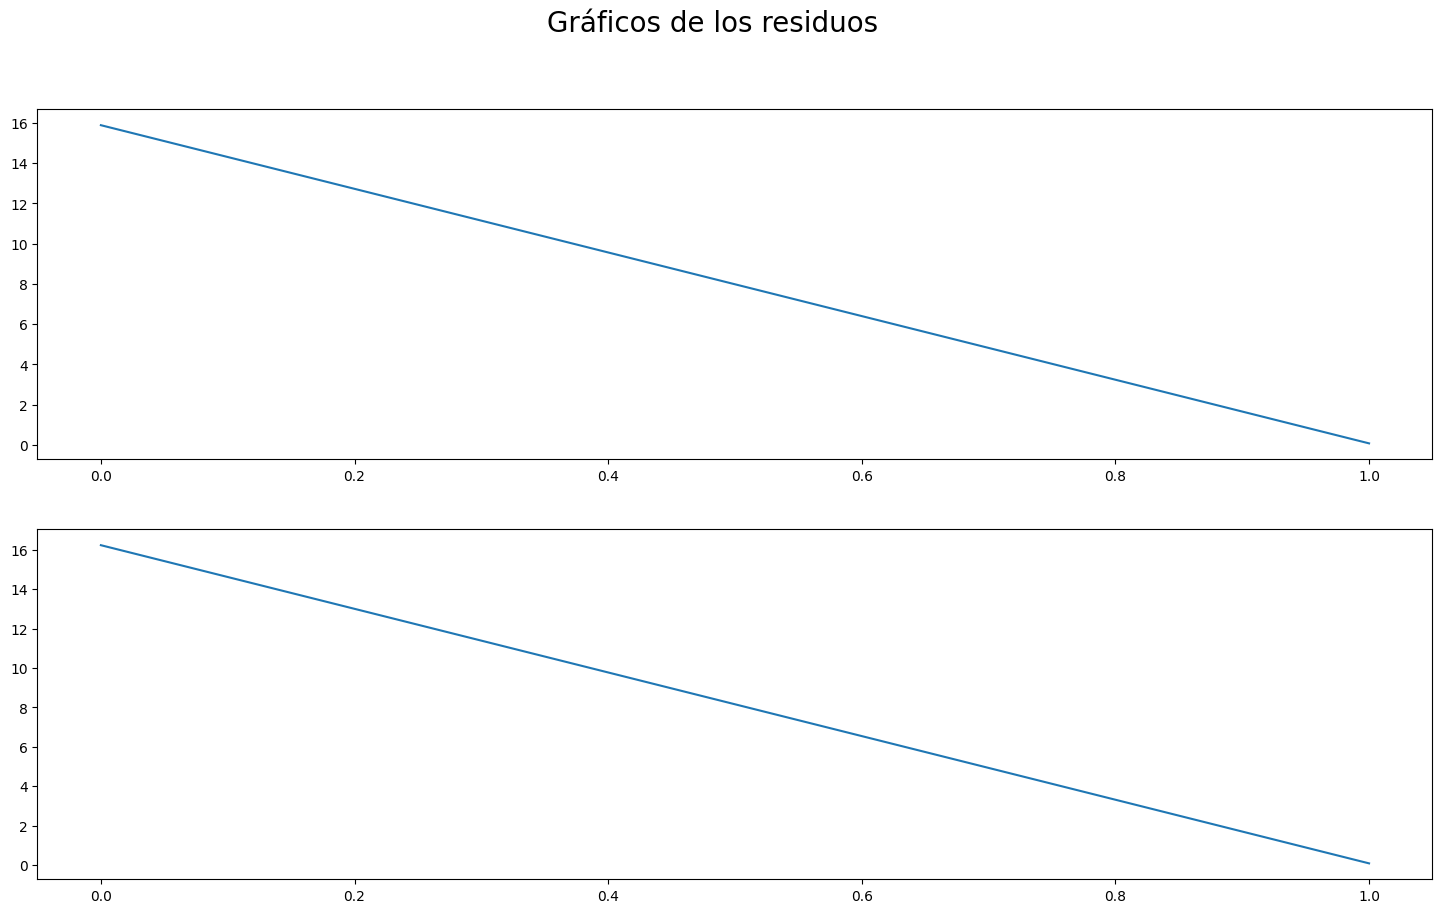

In [57]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals[i]) for i in range(2)]
plt.show()

#####Dickey - Fuller a los residuos

In [58]:
import statsmodels.tsa.stattools as ts

In [59]:
# Realizar la prueba ADF en cada serie de residuos y imprimir los resultados
print('ADF de los Residuos, p-valores:')
for i in range(residuals.shape[1]):
    result = ts.adfuller(residuals[:, i])
    print(f'Variable {i+1}: Estadístico ADF = {result[0]:.4f}, P-valor = {result[1]:.4f}')

ADF de los Residuos, p-valores:
Variable 1: Estadístico ADF = -2.1321, P-valor = 0.2318
Variable 2: Estadístico ADF = -4.6937, P-valor = 0.0001


#####ACF de los Residuos

In [60]:
import statsmodels.api as sm

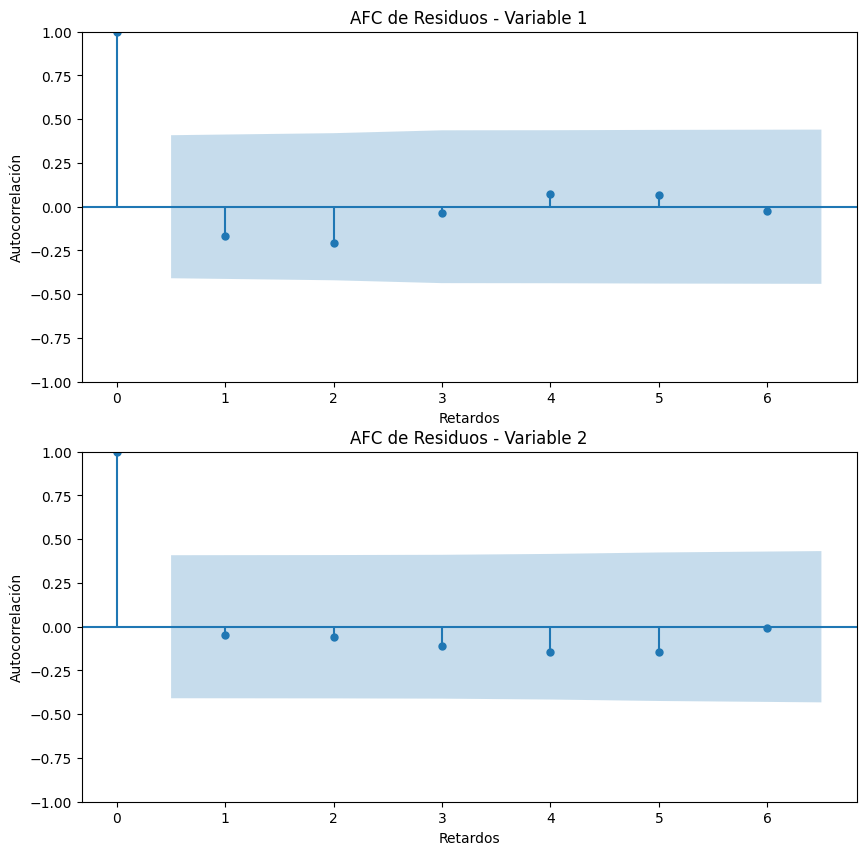

In [61]:
# Realizar y graficar la función de autocorrelación para cada serie de residuos
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 10))
for i in range(residuals.shape[1]):
    sm.graphics.tsa.plot_acf(residuals[:, i], lags=6, ax=axes[i], title=f'AFC de Residuos - Variable {i+1}')
    axes[i].set_ylabel('Autocorrelación')
    axes[i].set_xlabel('Retardos')

Esto sugiere que los residuos de la Variable 1 y 2 son aproximadamente ruido blanco, indicando un buen ajuste del modelo para esta variable. No hay evidencia de autocorrelaciones remanentes que el modelo no haya capturado.

####Valores predichos

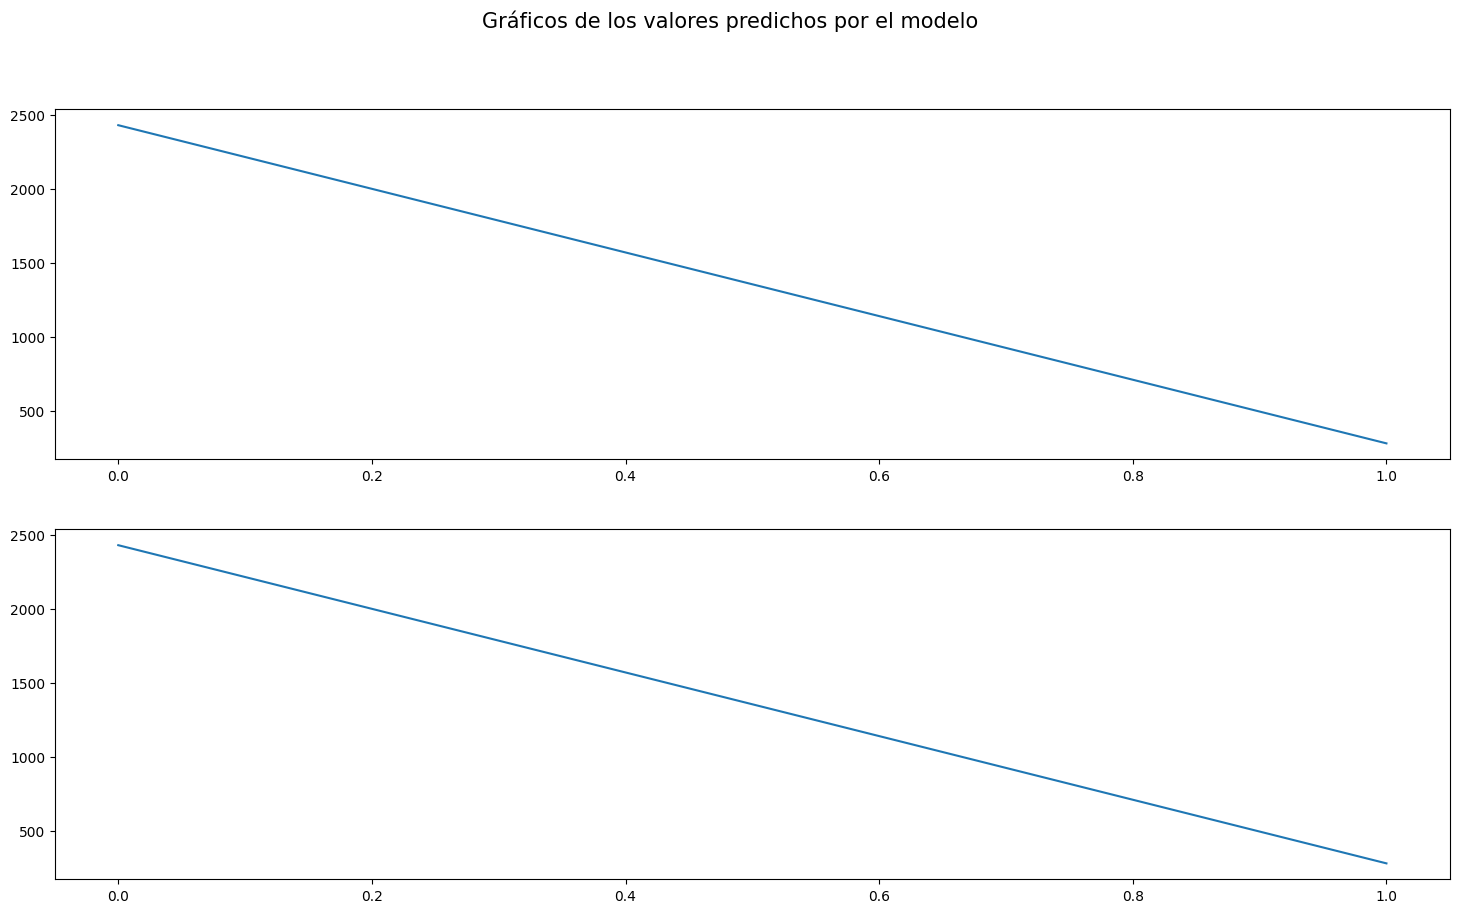

In [62]:
y_fitted = vecm_fit.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted[i]) for i in range(2)]
plt.show()

####Pronósticos a futuro

In [64]:
# Obtener los últimos valores (lag_order número de valores)
lag_order = vecm_fit.k_ar
last_observations = data[-lag_order:]

# Hacer predicciones para los próximos n pasos
n_steps = 6
forecast = vecm_fit.predict(n_steps)

pred = (pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns))
pred

,Compraventa_Unitario,Index_Turisme
Fecha,,
2021-07-01,2225.520567,273.419418
2021-08-01,2201.796047,273.317942
2021-09-01,2188.478347,273.266887
2021-10-01,2200.824316,272.895243
2021-11-01,2204.530291,272.930982
2021-12-01,2208.423872,272.983853


<Figure size 1200x1000 with 0 Axes>

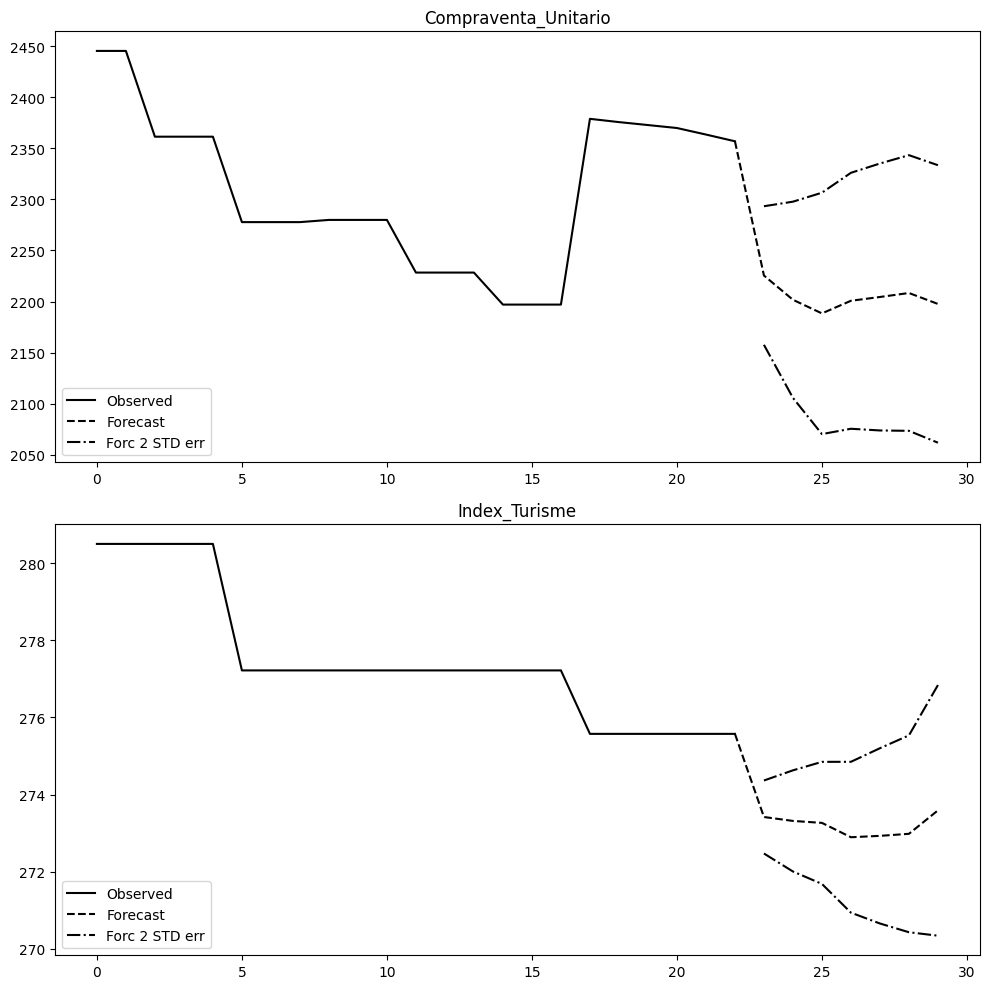

In [65]:

import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
vecm_fit.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


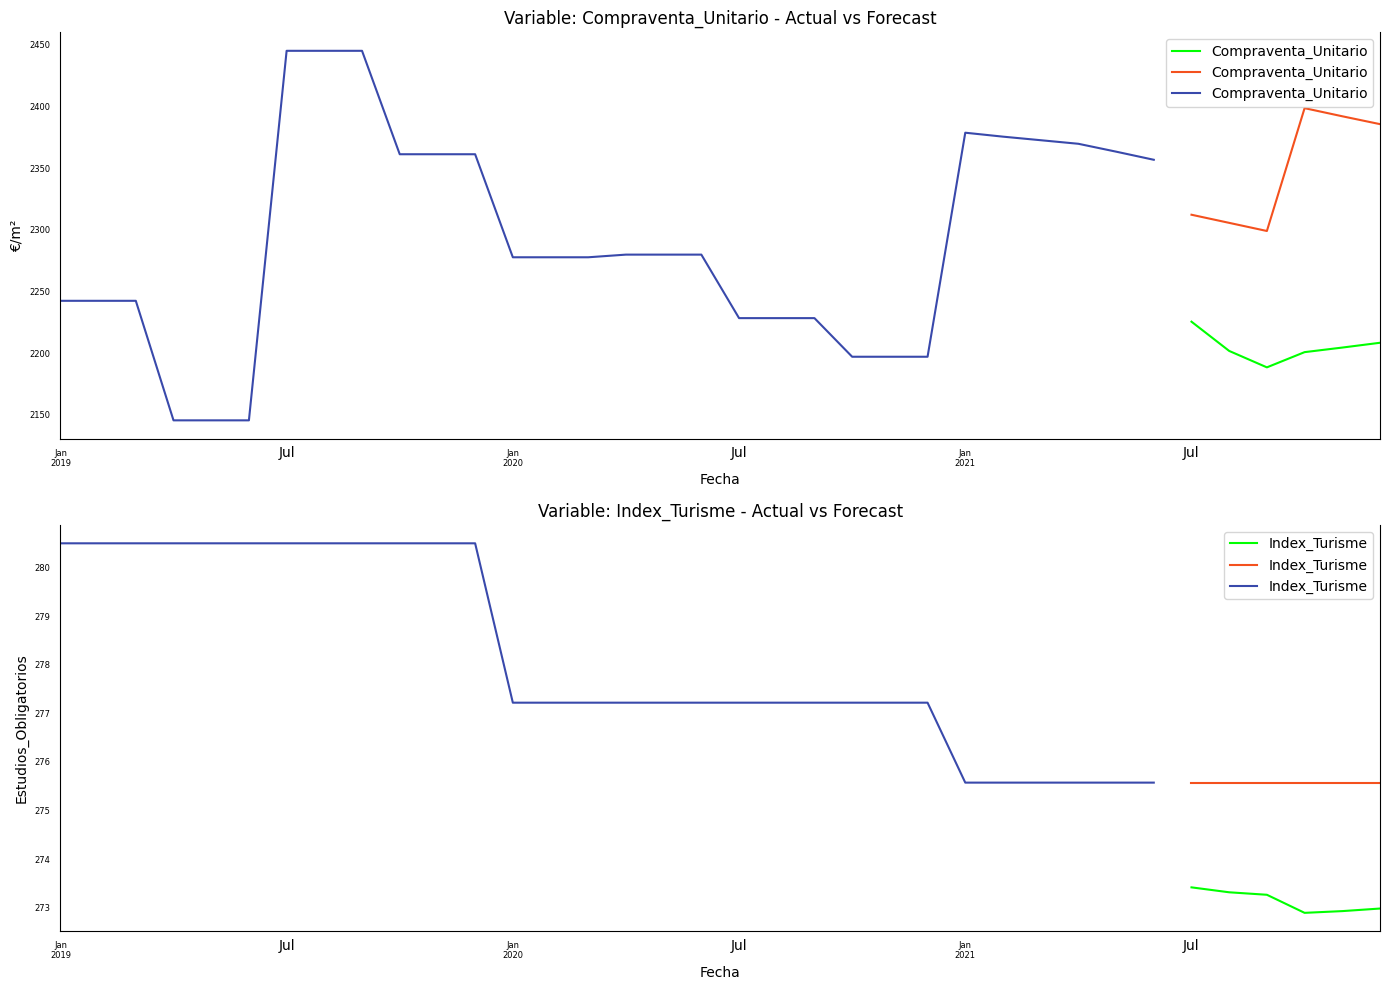

In [66]:

# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Estudios_Obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    pred[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

####Evaluando el modelo

In [67]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')


In [69]:
for i in ['Compraventa_Unitario','Index_Turisme']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , pred[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 22723.554992796766
MAE is : 144.00442421989564
RMSE is : 150.7433414542638
MAPE is : 6.098653658448944
R2 is : -10.960527683277117

Evaluation metric for Index_Turisme
Evaluation metric results:-
MSE is : 5.985097031731574
MAE is : 2.4377885411249927
RMSE is : 2.446445795788571
MAPE is : 0.8846236879901296
R2 is : 0.0



Los resultados de evaluación para Compraventa_Unitario indican un modelo sumamente ineficiente, reflejado por un R² extremadamente negativo de -10.96, lo que sugiere que el modelo es mucho peor que uno que simplemente usaría la media de los datos. Los altos valores de MSE, MAE, y RMSE demuestran grandes errores en las predicciones, y un MAPE del 6.10% también indica una precisión relativamente baja.

Por otro lado, para Index_Turisme, las métricas de error son bastante bajas (MSE, MAE, RMSE), indicando errores numéricos menores en las predicciones. Un MAPE de 0.88% refleja una alta precisión relativa en las predicciones. Sin embargo, un R² de 0.0 señala que el modelo no mejora las predicciones más allá de un modelo basado en la media, lo que podría indicar una falta de variabilidad explicativa en los datos o una inadecuada captura de relaciones dinámicas en el modelo.

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, pred)))

Mean absolute error: 73.22110638051032
Root mean squared error: 106.60567548172212


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_unitario y indice de motorizacion de turismos, tenemos que:

- Se ha comprobado que las variables tienen una baja correlacion inversa.
-Se ha realizado el test de Cointegracion y se ha demostrado que una de las series Compraventa_unitario esta cointegrada, lo que hace mas adecuado aplicar un modelo VECM, que un modelo VARMA
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del segundo orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR.
- Modelo VAR: las metricas de evaluación del modelo VAR, son bastante satisfactorias para la serie temporal de Index_Turisme y no tanto para la serie temporal de Compraventa_unitario
- Modelo VECM: las metricas de evaluación del modelo VECM, son bastante satisfactorias para la serie temporal de Index_Turisme y no tanto para la serie temporal de Compraventa_unitario.


